In [1]:
import pandas as pd
import numpy
import os

import nltk

import torch
!pip install transformers
import transformers

     |████████████████████████████████| 2.1MB 6.4MB/s 
     |████████████████████████████████| 901kB 21.4MB/s 
     |████████████████████████████████| 3.3MB 21.8MB/s 


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving FA18_sentences.xlsx to FA18_sentences.xlsx


In [4]:
df_fall_18_messages = pd.read_excel('FA18_sentences.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(6354, 2)


,Sentence,Recipient Gender
0,Hey @Katie Poteet I know you said we should em...,1
1,I’m planning to do the Baltimore Community Too...,1
2,@Mary Cassell I would email Dr. K anyway with ...,1
3,"If not, it’s still good for her to know what y...",1
4,"Ok, thanks a lot.",1


In [5]:
# Get the lists of sentences and their labels.
sentences = df_fall_18_messages['Sentence'].values
labels = df_fall_18_messages['Recipient Gender'].values

In [6]:
# Initialize the tokenizer with a pretrained model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Convert the string "granola bars" to tokenized vocabulary IDs
sentence_ids = df_fall_18_messages['Sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print('Original: ',sentences[0])
print('Ids: ',sentence_ids[0])
print('Tokens: ',tokenizer.convert_ids_to_tokens(sentence_ids[0]))

Original:  Hey @Katie Poteet I know you said we should email doctor Kaye with the volunteer opportunity we wanted but what if you don’t have a specific date you want to do yet?
Ids:  [101, 4931, 1030, 9734, 8962, 15558, 1045, 2113, 2017, 2056, 2057, 2323, 10373, 3460, 23686, 2007, 1996, 6951, 4495, 2057, 2359, 2021, 2054, 2065, 2017, 2123, 1521, 1056, 2031, 1037, 3563, 3058, 2017, 2215, 2000, 2079, 2664, 1029, 102]
Tokens:  ['[CLS]', 'hey', '@', 'katie', 'pot', '##eet', 'i', 'know', 'you', 'said', 'we', 'should', 'email', 'doctor', 'kaye', 'with', 'the', 'volunteer', 'opportunity', 'we', 'wanted', 'but', 'what', 'if', 'you', 'don', '’', 't', 'have', 'a', 'specific', 'date', 'you', 'want', 'to', 'do', 'yet', '?', '[SEP]']


In [ ]:
max_len = 0
for id_vector in sentence_ids.values:
    if len(id_vector) > max_len:
        max_len = len(id_vector)

padded_ids = numpy.array([i + [0]*(max_len-len(i)) for i in sentence_ids.values])
print("max id array length: ", max_len)

max id array length:  105


In [ ]:
attention_mask = numpy.where(padded_ids != 0, 1, 0)
print(attention_mask.shape)

(6354, 105)


In [ ]:
# Convert lists to tensors
ids_tensor = torch.LongTensor(padded_ids)
attention_masks_tensor = torch.tensor(attention_mask)

In [ ]:
ids_batches = torch.tensor_split(ids_tensor, 100)
attention_masks_batches = torch.tensor_split(attention_masks_tensor, 100)

In [ ]:
model = transformers.BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Set the device to GPU (cuda) if available, otherwise stick with CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
'''
model_output: BaseModelOutputWithPoolingAndCrossAttentions
      last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the 
      output of the last layer of the model.

      pooler_output (torch.FloatTensor of shape (batch_size, hidden_size)) – Last layer hidden-state of the first token of the 
      sequence (classification token) further processed by a Linear layer and a Tanh activation function. 
      The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

      hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when 
      config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output 
      of each layer) of shape (batch_size, sequence_length, hidden_size).Hidden-states of the model at the output of each 
      layer plus the initial embedding outputs.

https://huggingface.co/transformers/main_classes/output.html
'''

embeddings = []
for i in range(0,len(ids_batches)):
  with torch.no_grad():
    ids_batch = ids_batches[i].to(device)
    attention_masks_batch = attention_masks_batches[i].to(device)
    model_output = model(ids_batch, attention_mask=attention_masks_batch)
    # Get last hidden state from tuple returned from model
    last_hidden_state = model_output[0].cpu()
    
    # For each sentence in a batch
    for sentence in last_hidden_state: 
      # Get emmbedding for first token ([CLS])
      embeddings.append(sentence[0])
    
    ids_batch.cpu()
    attention_masks_batch.cpu()
    del model_output, ids_batch, attention_masks_batch
    torch.cuda.empty_cache()

In [ ]:
print("len(embeddings): ",len(embeddings))
print("embeddings[0].shape: ",embeddings[0].shape)

len(embeddings):  6354
embeddings[0].shape:  torch.Size([768])


In [ ]:
numpy_array = []
for embedding in embeddings:
  numpy_array.append(embedding.numpy())

X = numpy.array(numpy_array)
y = df_fall_18_messages["Recipient Gender"]

In [ ]:
df_features = pd.DataFrame(X)
df_features.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
3154,0.279578,-0.153533,-0.234437,0.054164,0.057772,-0.149382,0.532575,0.583567,-0.305407,-0.193732,-0.006841,-0.633726,-0.204653,0.163323,0.091511,0.165980,-0.029230,0.622729,0.363196,0.446545,0.149097,-0.121890,-0.095191,-0.021744,-0.097931,-0.275602,-0.068888,0.037615,-0.155489,-0.069284,0.195589,-0.032312,-0.227916,-0.252238,0.282812,0.043574,0.079997,0.056487,-0.051637,0.200767,...,0.062972,-0.508332,-0.247837,0.091102,-0.000801,0.026632,-0.160224,-0.117408,0.099556,-0.134289,-0.349096,0.352174,0.278086,-0.338788,-0.356639,0.405804,0.571006,0.098282,0.023855,-0.664829,0.266952,-0.256381,0.345070,0.407927,-7.528857,0.368115,0.070187,-0.597815,0.266644,-0.399936,-0.070742,-0.401815,0.358518,-0.464408,0.316487,-0.038343,-0.154444,-0.540360,0.218350,0.369504
2892,-0.139322,0.050318,-0.050363,-0.162064,-0.446361,-0.575043,0.475383,0.549649,0.093238,-0.400455,-0.354006,-0.083817,-0.314904,0.645628,0.345232,0.079884,-0.411670,0.391415,0.183423,-0.235963,-0.161149,-0.041473,-0.020309,-0.019613,0.023619,-0.246400,0.067217,-0.304000,-0.151113,0.311132,0.268303,0.286366,-0.657279,0.296580,-0.297199,0.170490,0.009121,0.309414,-0.074530,0.039092,...,-0.087832,-0.107093,-0.391167,0.284849,-0.634053,-0.000102,-0.110829,-0.066894,-0.119985,0.330882,-0.173505,0.815177,0.137314,-0.015449,0.370985,0.535364,0.279643,-0.309391,0.080370,0.285902,0.202510,-0.044770,0.098801,-0.003973,-7.350491,-0.443077,-0.287890,-0.112476,0.446208,-0.126324,0.109541,-0.037666,0.207518,-0.161789,-0.045041,-0.364930,-0.058631,-0.290070,0.260969,0.032437
1367,-0.123137,0.161302,0.001234,0.030448,-0.247531,-0.072720,-0.001706,0.269038,-0.058014,-0.132209,-0.267632,-0.071179,-0.041266,0.076731,0.197315,-0.004503,-0.083746,0.131318,0.069784,-0.273903,-0.158663,0.115208,-0.134675,-0.274789,-0.061994,-0.190785,0.135280,-0.130710,-0.063052,0.392151,0.115147,-0.035766,-0.081318,0.075713,-0.235339,-0.137516,0.044584,0.175271,0.048209,0.023405,...,-0.226708,-0.163739,-0.072251,0.484708,-0.154423,-0.084078,-0.097128,0.017246,-0.120185,0.007282,0.094375,0.110626,-0.089989,-0.049316,0.191785,0.142130,0.283179,0.051745,0.006025,0.050946,-0.204614,-0.194649,0.137897,0.098931,-8.540627,-0.093423,-0.158638,-0.279031,0.166203,0.141452,0.096975,-0.035828,0.079397,-0.009008,0.001281,0.027574,0.050122,-0.026519,0.298698,0.438693
3804,0.064484,0.112836,0.184944,-0.029359,-0.230980,-0.399629,0.104782,0.246633,0.215279,-0.277077,0.014187,-0.015833,-0.013425,0.155254,0.019352,-0.151311,-0.204869,0.034749,0.148587,-0.003532,0.041445,-0.014028,-0.033731,-0.103968,0.036191,-0.138556,0.053588,-0.367702,0.245672,0.172870,0.050236,-0.178078,-0.400897,-0.152786,0.042996,0.077262,-0.090309,0.091304,-0.078686,-0.149808,...,0.044403,-0.114059,-0.164455,-0.052681,-0.207475,0.016595,0.089094,-0.374178,-0.070617,-0.093807,-0.167856,0.345741,-0.064925,0.119203,-0.004075,0.504372,0.305251,0.038028,-0.108098,0.030905,0.119663,-0.160355,-0.059540,0.008232,-8.227970,-0.188189,-0.182513,0.006779,-0.134192,0.105130,-0.412277,-0.028047,-0.107278,0.025382,-0.084332,0.036818,-0.035262,-0.282251,0.254791,0.416548
1740,-0.135182,0.243332,0.037387,-0.101259,-0.225128,-0.232087,0.103272,0.585362,-0.147522,0.158251,-0.096809,-0.008860,-0.012228,0.251811,0.104072,-0.168540,-0.245230,0.194891,-0.108581,-0.202534,0.048835,-0.126133,-0.100097,0.008151,-0.235607,-0.088785,0.040521,-0.202021,0.117896,0.154183,0.229348,-0.029571,-0.198610,0.123274,-0.232734,0.119141,-0.014998,0.174178,-0.088709,0.059260,...,-0.008836,-0.015933,-0.251765,0.137402,-0.337371,0.078837,-0.027392,-0.205486,0.064230,-0.089911,-0.145390,0.273250,-0.385526,-0.108535,0.092317,0.321951,0.001874,0.031806,0.027889,-0.099824,0.032487,-0.191347,-0.247185,0.049384,-9.169405,-0.310088

In [ ]:
# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [ ]:
# Print y shape, head, unique values and number of instances in each class
print(y.shape)
print(y.unique())
print(y.value_counts())

# split into training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6354,)
[1 2 0]
2    2918
1    1794
0    1642
Name: Recipient Gender, dtype: int64
(5083, 768)
(5083,)
(1271, 768)
(1271,)


In [ ]:
def get_best_estimator(clf, params):
    # Metrics to use for optimization
    # metrics = ['accuracy','f1', 'f1_macro', 'f1_weighted','precision','recall']
    
    # Optimize based on f1_macro score
    grid_search = GridSearchCV(clf, param_grid = params, cv = 3, n_jobs = -1, scoring = 'f1_macro', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get estimator with best parameter valuese
    best_estimator = grid_search.best_estimator_
    print(best_estimator)
    
    # Return best_estimator
    return best_estimator

In [ ]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    #svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    #svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    #print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    #print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

In [ ]:
def svm():
    # Parameters to optimize for svm
    param_grid = {'probability': [True],
                  'C': [1, 5, 10],
                  'kernel': ['rbf'],
                  'gamma': ['auto', 'scale', 0.1, 0.01, 0.001],
                 }
    # Get optimized parameters from grid search
    svm_clf = SVC()
    optimized_svm_clf = get_best_estimator(svm_clf, param_grid)
    optimized_svm_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_svm_clf.predict(X_test)
    print_results(optimized_svm_clf, y_pred)

In [ ]:
def random_forest():
    # Parameters to optimize for rf
    param_grid = {
        'max_depth': [10, 50, 100],
        'min_samples_leaf': [3, 4],
        'min_samples_split': [3, 5],
        'n_estimators': [100, 200]
    }
    
    # Get optimized parameters from grid search
    rf_clf = RandomForestClassifier()
    optimized_rf_clf = get_best_estimator(rf_clf, param_grid)
    optimized_rf_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_rf_clf.predict(X_test)
    print_results(optimized_rf_clf, y_pred)

In [ ]:
def mlp():
    # Parameters to optimize for rf
    param_grid = {
        'hidden_layer_sizes': [(100,50,10), (100, 50), (20,10,5)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.05],
        'max_iter': [500]
    }
    
    # Get optimized parameters from grid search
    mlp_clf = MLPClassifier()
    optimized_mlp_clf = get_best_estimator(mlp_clf, param_grid)
    optimized_mlp_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_mlp_clf.predict(X_test)
    print_results(optimized_mlp_clf, y_pred)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 18.0min finished


SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy Score ->  57.04169944925256
              precision    recall  f1-score   support

           0       0.49      0.29      0.37       334
           1       0.45      0.47      0.46       347
           2       0.66      0.79      0.71       590

    accuracy                           0.57      1271
   macro avg       0.53      0.52      0.51      1271
weighted avg       0.56      0.57      0.55      1271



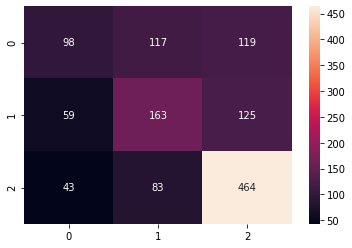

In [ ]:
svm()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy Score ->  51.534225019669556
              precision    recall  f1-score   support

           0       0.41      0.13      0.20       334
           1       0.38      0.28      0.32       347
           2       0.57      0.87      0.69       590

    accuracy                           0.52      1271
   macro avg       0.45      0.43      0.40      1271
weighted avg       0.47      0.52      0.46      1271



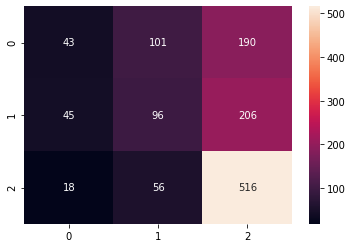

In [ ]:
random_forest()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Accuracy Score ->  49.33123524783635
              precision    recall  f1-score   support

           0       0.33      0.35      0.34       334
           1       0.40      0.38      0.39       347
           2       0.64      0.64      0.64       590

    accuracy                           0.49      1271
   macro avg       0.46      0.46      0.46      1271
weighted avg       0.49      0.49      0.49      1271



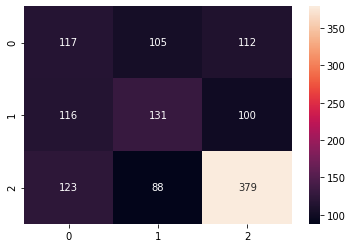

In [ ]:
mlp()